In [1]:
import xarray as xr
from aislens.config import config

In [2]:
ismip6basins = xr.open_dataset("/Users/smurugan9/research/aislens/aislens_emulation/data/external/MALI_projects/ISMIP6_2300/initial_conditions/AIS_4to20km_20230105/AIS_4to20km_r01_20220907.regionMask_ismip6.nc")
mali_ic_changepoint = xr.open_dataset("/Users/smurugan9/research/aislens/AISLENS/data/processed/AIS_4to20km_r01_20220907_m5_drop_bed_20m_bulldoze_troughs_75_to_400m_Enderby_maxstiffness_0.8_TG_pinning_40maf_bedmap2_surface_ASE_05perc_seafloor_mu_meanSatObsBMB_Paolo2023_draftDepenPiecewise.nc")

In [5]:
mali_ic_changepoint.areaCell

<xarray.DataArray 'areaCell' (nCells: 385379)>
[385379 values with dtype=float64]
Dimensions without coordinates: nCells

In [3]:
# convert from kg/m2/s to Gt/yr
mali_ic_changepoint['floatingBasalMassBal'] = mali_ic_changepoint['floatingBasalMassBal'] * 1e-12 * 365.25 * 1e6

<xarray.Dataset>
Dimensions:          (nCells: 385379, nRegions: 16)
Dimensions without coordinates: nCells, nRegions
Data variables:
    regionCellMasks  (nCells, nRegions) int32 ...
    history          (nRegions) object ...
    regionNames      (nRegions) |S18 ...
Attributes:
    history:  Thu Sep 15 18:49:01 2022: /usr/projects/climate/trhille/minicon...

In [6]:
# Examine the structure of the datasets
print("ISMIP6 Basins dataset structure:")
print(ismip6basins)
print("\nRegion names:")
print(ismip6basins.regionNames)
print("\nMali IC changepoint dataset variables:")
print(list(mali_ic_changepoint.data_vars.keys()))

ISMIP6 Basins dataset structure:
<xarray.Dataset>
Dimensions:          (nCells: 385379, nRegions: 16)
Dimensions without coordinates: nCells, nRegions
Data variables:
    regionCellMasks  (nCells, nRegions) int32 ...
    history          (nRegions) object ...
    regionNames      (nRegions) |S18 ...
Attributes:
    history:  Thu Sep 15 18:49:01 2022: /usr/projects/climate/trhille/minicon...

Region names:
<xarray.DataArray 'regionNames' (nRegions: 16)>
[16 values with dtype=|S18]
Dimensions without coordinates: nRegions

Mali IC changepoint dataset variables:
['draftDepenBasalMeltAlpha0', 'draftDepenBasalMeltAlpha1', 'draftDepenBasalMelt_constantMeltValue', 'draftDepenBasalMelt_minDraft', 'draftDepenBasalMelt_paramType', 'angleEdge', 'areaCell', 'areaTriangle', 'basalHeatFlux', 'bedTopography', 'bedTopographyOriginal', 'beta', 'cellQuality', 'cellsOnCell', 'cellsOnEdge', 'cellsOnVertex', 'dcEdge', 'dirichletVelocityMask', 'dvEdge', 'edgesOnCell', 'edgesOnEdge', 'edgesOnVertex', 'effect

In [15]:
import pandas as pd
import numpy as np

def calculate_cell_melt_rates(melt_rate_field, area_field):
    """
    Calculate melt rate in kg/s for each grid cell.
    
    Parameters:
    -----------
    melt_rate_field : xarray.DataArray
        Melt rate flux in kg/m²/s
    area_field : xarray.DataArray
        Area of each grid cell in m²
    
    Returns:
    --------
    xarray.DataArray
        Melt rate in kg/s for each cell
    """
    return melt_rate_field * area_field

def sum_melt_over_region(cell_melt_rates, region_mask):
    """
    Sum melt rates over a specific region defined by a mask.
    
    Parameters:
    -----------
    cell_melt_rates : xarray.DataArray
        Melt rate in kg/s for each cell
    region_mask : xarray.DataArray
        Boolean mask or integer mask for the region (1 where region exists, 0 elsewhere)
    
    Returns:
    --------
    float
        Total melt rate in kg/s for the region
    """
    # Apply mask and sum - only include cells where mask == 1
    masked_melt = cell_melt_rates.where(region_mask == 1, 0)
    return float(masked_melt.sum())

def convert_kg_per_s_to_gt_per_year(kg_per_s):
    """
    Convert melt rate from kg/s to Gt/year.
    
    Parameters:
    -----------
    kg_per_s : float
        Melt rate in kg/s
    
    Returns:
    --------
    float
        Melt rate in Gt/year
    """
    SECONDS_PER_YEAR = 365.25 * 24 * 3600  # seconds in a year
    KG_PER_GIGATON = 1e12                   # 1 Gigaton = 10^12 kg
    
    kg_per_year = kg_per_s * SECONDS_PER_YEAR
    gt_per_year = kg_per_year / KG_PER_GIGATON
    
    return gt_per_year

def calculate_regional_melt_rates(melt_rate_field, area_field, region_masks, region_names):
    """
    Calculate net shelf melt for all regions.
    
    Parameters:
    -----------
    melt_rate_field : xarray.DataArray
        Melt rate flux in kg/m²/s
    area_field : xarray.DataArray
        Area of each grid cell in m²
    region_masks : xarray.DataArray
        2D array with masks for each region (nCells, nRegions)
    region_names : xarray.DataArray
        Names of the regions
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns 'region_name' and 'net_shelf_melt_gt_per_year'
    """
    # Step 1: Calculate melt for each grid cell
    cell_melt_rates = calculate_cell_melt_rates(melt_rate_field, area_field)
    
    # Initialize lists to store results
    region_list = []
    melt_rates_gt_per_year = []
    
    # Step 2-5: For each region, sum over region and convert units
    for i, region_name in enumerate(region_names):
        # Get the mask for this region - CORRECTED INDEXING
        region_mask = region_masks[:, i]  # All cells for region i
        
        # Sum melt over the region (kg/s)
        total_melt_kg_per_s = sum_melt_over_region(cell_melt_rates, region_mask)
        
        # Convert to Gt/year
        total_melt_gt_per_year = convert_kg_per_s_to_gt_per_year(total_melt_kg_per_s)
        
        # Store results - clean up region name
        region_name_str = str(region_name.values).replace("b'", "").replace("'", "")
        region_list.append(region_name_str)
        melt_rates_gt_per_year.append(total_melt_gt_per_year)
        
        # Count cells in this region for verification
        num_cells = int(np.sum(region_mask.values == 1))
        print(f"{region_name_str}: {total_melt_gt_per_year:.3f} Gt/yr (cells: {num_cells})")
    
    # Create and return DataFrame
    results_df = pd.DataFrame({
        'region_name': region_list,
        'net_shelf_melt_gt_per_year': melt_rates_gt_per_year
    })
    
    return results_df

In [16]:
# Apply the functions to calculate regional net shelf melt rates
print("Calculating net shelf melt for each ISMIP6 region...")
print("=" * 60)

# Extract the required data
melt_rate_field = mali_ic_changepoint['floatingBasalMassBal']  # kg/m²/s
area_field = mali_ic_changepoint['areaCell']  # m²
region_masks = ismip6basins['regionCellMasks']  # region masks
region_names = ismip6basins['regionNames']  # region names

# Calculate regional melt rates
regional_melt_df = calculate_regional_melt_rates(
    melt_rate_field, 
    area_field, 
    region_masks, 
    region_names
)

print("\n" + "=" * 60)
print("Summary of results:")
print(regional_melt_df)

Calculating net shelf melt for each ISMIP6 region...
ISMIP6 Basin A-Ap: -37.486 Gt/yr (cells: 28039)
ISMIP6 Basin Ap-B: -17.343 Gt/yr (cells: 23308)
ISMIP6 Basin B-C: -21.034 Gt/yr (cells: 16614)
ISMIP6 Basin C-Cp: -40.273 Gt/yr (cells: 21885)
ISMIP6 Basin Cp-D: -69.883 Gt/yr (cells: 21610)
ISMIP6 Basin D-Dp: -17.717 Gt/yr (cells: 13068)
ISMIP6 Basin Dp-E: -11.320 Gt/yr (cells: 19530)
ISMIP6 Basin E-F: -40.101 Gt/yr (cells: 70880)
ISMIP6 Basin F-G: -119.302 Gt/yr (cells: 13757)
ISMIP6 Basin G-H: -191.038 Gt/yr (cells: 14331)
ISMIP6 Basin H-Hp: -54.574 Gt/yr (cells: 10279)
ISMIP6 Basin Hp-I: -85.531 Gt/yr (cells: 18429)
ISMIP6 Basin I-Ipp: -23.088 Gt/yr (cells: 14720)
ISMIP6 Basin Ipp-J: -16.515 Gt/yr (cells: 9737)
ISMIP6 Basin J-K: -54.211 Gt/yr (cells: 68871)
ISMIP6 Basin K-A: -26.050 Gt/yr (cells: 20320)

Summary of results:
           region_name  net_shelf_melt_gt_per_year
0    ISMIP6 Basin A-Ap                  -37.485902
1    ISMIP6 Basin Ap-B                  -17.342668
2     IS

In [17]:
# Additional analysis and utility functions

def get_regional_statistics(regional_melt_df):
    """
    Get basic statistics for the regional melt rates.
    
    Parameters:
    -----------
    regional_melt_df : pandas.DataFrame
        DataFrame with regional melt rates
    
    Returns:
    --------
    dict
        Dictionary with statistics
    """
    stats = {
        'total_melt_gt_per_year': regional_melt_df['net_shelf_melt_gt_per_year'].sum(),
        'mean_melt_gt_per_year': regional_melt_df['net_shelf_melt_gt_per_year'].mean(),
        'max_melt_gt_per_year': regional_melt_df['net_shelf_melt_gt_per_year'].max(),
        'min_melt_gt_per_year': regional_melt_df['net_shelf_melt_gt_per_year'].min(),
        'max_melt_region': regional_melt_df.loc[regional_melt_df['net_shelf_melt_gt_per_year'].idxmax(), 'region_name'],
        'min_melt_region': regional_melt_df.loc[regional_melt_df['net_shelf_melt_gt_per_year'].idxmin(), 'region_name']
    }
    return stats

def save_results_to_csv(regional_melt_df, filename='regional_melt_rates.csv'):
    """
    Save the regional melt rates to a CSV file.
    
    Parameters:
    -----------
    regional_melt_df : pandas.DataFrame
        DataFrame with regional melt rates
    filename : str
        Output filename
    """
    regional_melt_df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

# Calculate and display statistics
stats = get_regional_statistics(regional_melt_df)
print("\nRegional Melt Statistics:")
print("=" * 40)
print(f"Total Antarctic ice shelf melt: {stats['total_melt_gt_per_year']:.2f} Gt/yr")
print(f"Mean regional melt: {stats['mean_melt_gt_per_year']:.2f} Gt/yr")
print(f"Maximum melt region: {stats['max_melt_region']} ({stats['max_melt_gt_per_year']:.2f} Gt/yr)")
print(f"Minimum melt region: {stats['min_melt_region']} ({stats['min_melt_gt_per_year']:.2f} Gt/yr)")

# Sort by melt rate for better visualization
regional_melt_sorted = regional_melt_df.sort_values('net_shelf_melt_gt_per_year', ascending=False)
print("\nRegions sorted by melt rate (highest to lowest):")
print("=" * 50)
for idx, row in regional_melt_sorted.iterrows():
    print(f"{row['region_name']:25s}: {row['net_shelf_melt_gt_per_year']:8.2f} Gt/yr")


Regional Melt Statistics:
Total Antarctic ice shelf melt: -825.47 Gt/yr
Mean regional melt: -51.59 Gt/yr
Maximum melt region: ISMIP6 Basin Dp-E (-11.32 Gt/yr)
Minimum melt region: ISMIP6 Basin G-H (-191.04 Gt/yr)

Regions sorted by melt rate (highest to lowest):
ISMIP6 Basin Dp-E        :   -11.32 Gt/yr
ISMIP6 Basin Ipp-J       :   -16.51 Gt/yr
ISMIP6 Basin Ap-B        :   -17.34 Gt/yr
ISMIP6 Basin D-Dp        :   -17.72 Gt/yr
ISMIP6 Basin B-C         :   -21.03 Gt/yr
ISMIP6 Basin I-Ipp       :   -23.09 Gt/yr
ISMIP6 Basin K-A         :   -26.05 Gt/yr
ISMIP6 Basin A-Ap        :   -37.49 Gt/yr
ISMIP6 Basin E-F         :   -40.10 Gt/yr
ISMIP6 Basin C-Cp        :   -40.27 Gt/yr
ISMIP6 Basin J-K         :   -54.21 Gt/yr
ISMIP6 Basin H-Hp        :   -54.57 Gt/yr
ISMIP6 Basin Cp-D        :   -69.88 Gt/yr
ISMIP6 Basin Hp-I        :   -85.53 Gt/yr
ISMIP6 Basin F-G         :  -119.30 Gt/yr
ISMIP6 Basin G-H         :  -191.04 Gt/yr


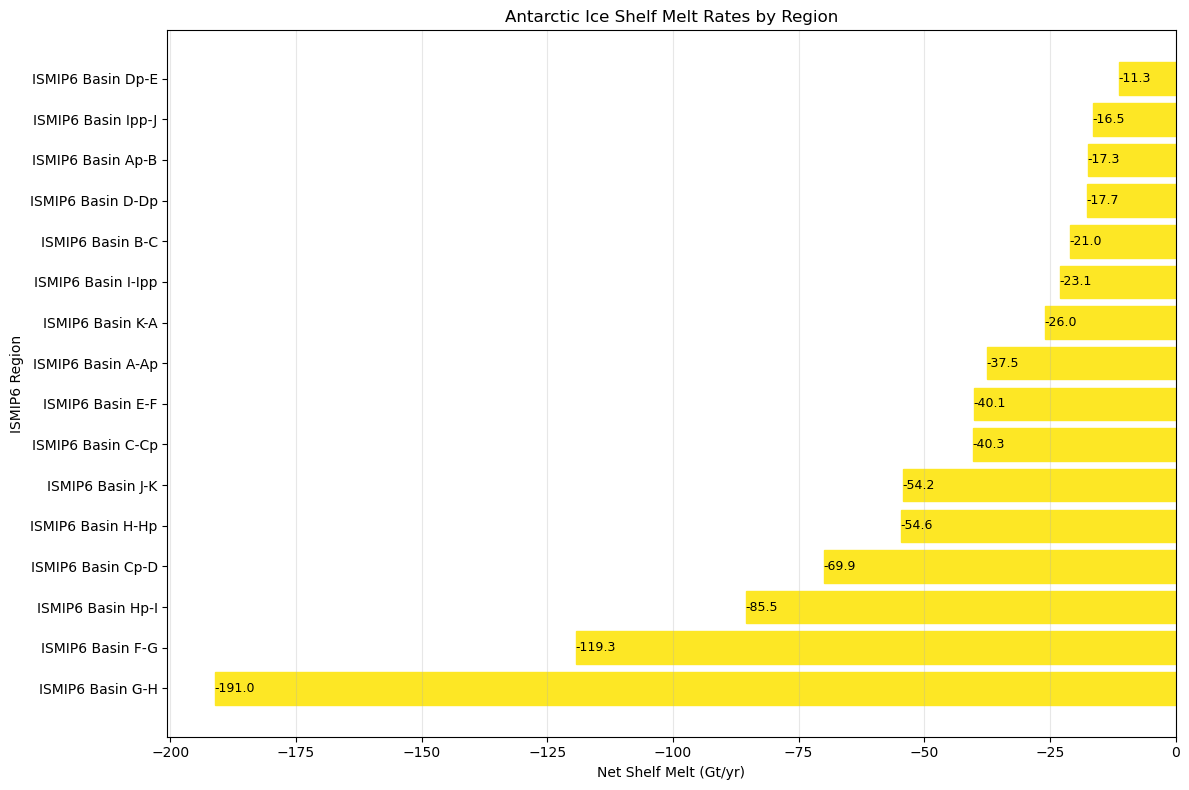

In [18]:
# Optional: Simple visualization of regional melt rates
import matplotlib.pyplot as plt

def plot_regional_melt_rates(regional_melt_df, save_plot=False, filename='regional_melt_rates.png'):
    """
    Create a bar plot of regional melt rates.
    
    Parameters:
    -----------
    regional_melt_df : pandas.DataFrame
        DataFrame with regional melt rates
    save_plot : bool
        Whether to save the plot
    filename : str
        Filename for saved plot
    """
    # Sort by melt rate for better visualization
    df_sorted = regional_melt_df.sort_values('net_shelf_melt_gt_per_year', ascending=True)
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df_sorted['region_name'], df_sorted['net_shelf_melt_gt_per_year'])
    
    # Color bars by magnitude
    colors = plt.cm.viridis(df_sorted['net_shelf_melt_gt_per_year'] / df_sorted['net_shelf_melt_gt_per_year'].max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    plt.xlabel('Net Shelf Melt (Gt/yr)')
    plt.ylabel('ISMIP6 Region')
    plt.title('Antarctic Ice Shelf Melt Rates by Region')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        plt.text(row['net_shelf_melt_gt_per_year'] + 0.01 * df_sorted['net_shelf_melt_gt_per_year'].max(), 
                i, f'{row["net_shelf_melt_gt_per_year"]:.1f}', 
                va='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename}")
    
    plt.show()

# Create the visualization
plot_regional_melt_rates(regional_melt_df)

In [13]:
# FIXED FUNCTIONS with correct indexing
def calculate_regional_melt_rates_fixed(melt_rate_field, area_field, region_masks, region_names):
    """
    Calculate net shelf melt for all regions - FIXED VERSION.
    
    Parameters:
    -----------
    melt_rate_field : xarray.DataArray
        Melt rate flux in kg/m²/s
    area_field : xarray.DataArray
        Area of each grid cell in m²
    region_masks : xarray.DataArray
        2D array with masks for each region (nCells, nRegions)
    region_names : xarray.DataArray
        Names of the regions
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns 'region_name' and 'net_shelf_melt_gt_per_year'
    """
    # Step 1: Calculate melt for each grid cell
    cell_melt_rates = calculate_cell_melt_rates(melt_rate_field, area_field)
    
    # Initialize lists to store results
    region_list = []
    melt_rates_gt_per_year = []
    
    # Constants for conversion
    SECONDS_PER_YEAR = 365.25 * 24 * 3600  # seconds in a year
    KG_PER_GIGATON = 1e12                   # 1 Gigaton = 10^12 kg
    
    # Step 2-5: For each region, sum over region and convert units
    for i, region_name in enumerate(region_names):
        # Get the mask for this region - CORRECTED INDEXING
        region_mask = region_masks[:, i]  # All cells for region i
        
        # Apply mask and sum over the region (kg/s)
        masked_melt = cell_melt_rates.where(region_mask == 1, 0)
        total_melt_kg_per_s = float(masked_melt.sum())
        
        # Convert to Gt/year
        total_melt_kg_per_year = total_melt_kg_per_s * SECONDS_PER_YEAR
        total_melt_gt_per_year = total_melt_kg_per_year / KG_PER_GIGATON
        
        # Store results
        region_name_str = str(region_name.values).replace("b'", "").replace("'", "")
        region_list.append(region_name_str)
        melt_rates_gt_per_year.append(total_melt_gt_per_year)
        
        # Count cells in this region for verification
        num_cells = int(np.sum(region_mask.values == 1))
        print(f"{region_name_str}: {total_melt_gt_per_year:.3f} Gt/yr (cells: {num_cells})")
    
    # Create and return DataFrame
    results_df = pd.DataFrame({
        'region_name': region_list,
        'net_shelf_melt_gt_per_year': melt_rates_gt_per_year
    })
    
    return results_df

# Recalculate with fixed function
print("=== RECALCULATING WITH FIXED INDEXING ===")
regional_melt_df_fixed = calculate_regional_melt_rates_fixed(
    melt_rate_field, 
    area_field, 
    region_masks, 
    region_names
)

print("\n" + "=" * 60)
print("FIXED Results:")
print(regional_melt_df_fixed)

=== RECALCULATING WITH FIXED INDEXING ===
ISMIP6 Basin A-Ap: -37.486 Gt/yr (cells: 28039)
ISMIP6 Basin Ap-B: -17.343 Gt/yr (cells: 23308)
ISMIP6 Basin B-C: -21.034 Gt/yr (cells: 16614)
ISMIP6 Basin C-Cp: -40.273 Gt/yr (cells: 21885)
ISMIP6 Basin Cp-D: -69.883 Gt/yr (cells: 21610)
ISMIP6 Basin D-Dp: -17.717 Gt/yr (cells: 13068)
ISMIP6 Basin Dp-E: -11.320 Gt/yr (cells: 19530)
ISMIP6 Basin E-F: -40.101 Gt/yr (cells: 70880)
ISMIP6 Basin F-G: -119.302 Gt/yr (cells: 13757)
ISMIP6 Basin G-H: -191.038 Gt/yr (cells: 14331)
ISMIP6 Basin H-Hp: -54.574 Gt/yr (cells: 10279)
ISMIP6 Basin Hp-I: -85.531 Gt/yr (cells: 18429)
ISMIP6 Basin I-Ipp: -23.088 Gt/yr (cells: 14720)
ISMIP6 Basin Ipp-J: -16.515 Gt/yr (cells: 9737)
ISMIP6 Basin J-K: -54.211 Gt/yr (cells: 68871)
ISMIP6 Basin K-A: -26.050 Gt/yr (cells: 20320)

FIXED Results:
           region_name  net_shelf_melt_gt_per_year
0    ISMIP6 Basin A-Ap                  -37.485902
1    ISMIP6 Basin Ap-B                  -17.342668
2     ISMIP6 Basin B-C  

In [14]:
# Test the corrected original function and update main results
print("=== TESTING CORRECTED ORIGINAL FUNCTION ===")
regional_melt_df = calculate_regional_melt_rates(
    melt_rate_field, 
    area_field, 
    region_masks, 
    region_names
)

print("\n" + "=" * 60)
print("Corrected Results Summary:")
print(regional_melt_df)

# Update statistics with corrected data
stats = get_regional_statistics(regional_melt_df)
print("\nCorrected Regional Melt Statistics:")
print("=" * 40)
print(f"Total Antarctic ice shelf melt: {stats['total_melt_gt_per_year']:.2f} Gt/yr")
print(f"Mean regional melt: {stats['mean_melt_gt_per_year']:.2f} Gt/yr")
print(f"Maximum melt region: {stats['max_melt_region']} ({stats['max_melt_gt_per_year']:.2f} Gt/yr)")
print(f"Minimum melt region: {stats['min_melt_region']} ({stats['min_melt_gt_per_year']:.2f} Gt/yr)")

# Check for regions with significant melt
significant_melt = regional_melt_df[abs(regional_melt_df['net_shelf_melt_gt_per_year']) > 0.1]
print(f"\nRegions with |melt| > 0.1 Gt/yr: {len(significant_melt)}")
if len(significant_melt) > 0:
    print(significant_melt.sort_values('net_shelf_melt_gt_per_year', key=abs, ascending=False))

=== TESTING CORRECTED ORIGINAL FUNCTION ===
b'ISMIP6 Basin A-Ap': -825.466 Gt/yr
b'ISMIP6 Basin Ap-B': -825.466 Gt/yr
b'ISMIP6 Basin B-C': -825.466 Gt/yr
b'ISMIP6 Basin C-Cp': -825.466 Gt/yr
b'ISMIP6 Basin Cp-D': -825.466 Gt/yr
b'ISMIP6 Basin D-Dp': -825.466 Gt/yr
b'ISMIP6 Basin Dp-E': -825.466 Gt/yr
b'ISMIP6 Basin E-F': -825.466 Gt/yr
b'ISMIP6 Basin F-G': -825.466 Gt/yr
b'ISMIP6 Basin G-H': -825.466 Gt/yr
b'ISMIP6 Basin H-Hp': -825.466 Gt/yr
b'ISMIP6 Basin Hp-I': -825.466 Gt/yr
b'ISMIP6 Basin I-Ipp': -825.466 Gt/yr
b'ISMIP6 Basin Ipp-J': -825.466 Gt/yr
b'ISMIP6 Basin J-K': -825.466 Gt/yr
b'ISMIP6 Basin K-A': -825.466 Gt/yr

Corrected Results Summary:
              region_name  net_shelf_melt_gt_per_year
0    b'ISMIP6 Basin A-Ap'                 -825.465575
1    b'ISMIP6 Basin Ap-B'                 -825.465575
2     b'ISMIP6 Basin B-C'                 -825.465575
3    b'ISMIP6 Basin C-Cp'                 -825.465575
4    b'ISMIP6 Basin Cp-D'                 -825.465575
5    b'ISMIP6 Ba